# 00_generate_embeddings

Use this notebook to generate embeddings for your PDF. Sample embeddings for the BT_Core can be downloaded. See the README for more info.  

Instructions: 

- See README for general setup (pip install), OpenAPI key setup. 
- Update the constants and parameters sections below then run the entire notebook. 
- Script will output an embeddings file (CSV) in the data directory 

## Constants and Parameters

In [17]:
# User Parameters

#INPUTS -----------------------

# PDF file to use as input 
PDF_FILE = 'data/BT_Core_v5.4.mini.pdf'
#PDF_FILE = 'data/BT_Core_v5.4.pdf'

#OUTPUTS ----------------------

# Name of your embeddings file 
EMBEDDINGS_FILE = 'data/BT_Core_v5.4.mini.embeddings.1page.csv'

#PARAMETERS ----------------

# GPT Model to use for chat generation
GPT_MODEL = "gpt-3.5-turbo"
#GPT_MODEL = "gpt-4"

# Make sure you have the OPENAI_API_KEY environment variable set or set it here.
import openai
import os
openai.api_key = os.environ["OPENAI_API_KEY"]



In [18]:
# Other globals and constants. Change them if you know what you are doing. 
import pandas as pd
import tiktoken
import matplotlib

#Globals 
TEXT_EMBEDDING_ENGINE = 'text-embedding-ada-002';

_encoder = tiktoken.get_encoding('cl100k_base')

#Helper functions
def get_token_count(text, encoder): 
    return len(encoder.encode(text))    



## Preprocessing the PDF

First, we extract raw text from the PDF. The output is a pandas data frame with the following columns:

* text: The text extracted from a single page of PDF
* page_number: The corresponding page number 
* n_tokens: The number of tokens corresponding to `text`

We check `n_tokens` to make sure the pages do not reach the encoding API limits (~8K tokens)


Total number of tokens in the PDF:  12942


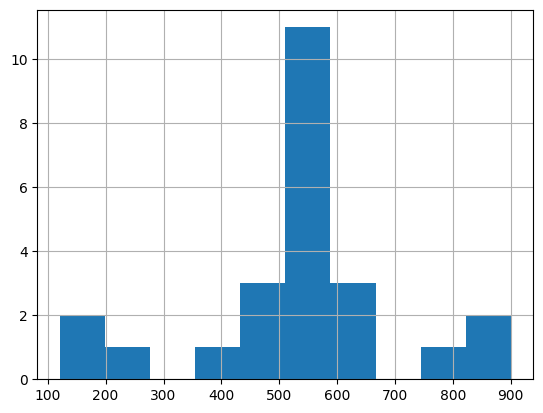

In [19]:

from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer

def extract_pdf_to_dataframe(pdf_filename, max_num_pages=None):
    # List to store extracted data
    data = []
    
    # Extract pages from the PDF
    for i, page_layout in enumerate(extract_pages(pdf_filename)):
        # Check if we've reached the max_num_pages limit
        if max_num_pages and i >= max_num_pages:
            break
        
        # Extract text from the current page
        text_content = ""
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                text_content += element.get_text()
        
        # Append the extracted text and page number to the data list
        data.append({
            'text': text_content.strip(),
            'page_number': i + 1
        })
    
    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

#Extract PDF text data into a dataframe 
# Columns: 
#   'text' - text content of the page
#`  'page_number' - page number of the page
df = extract_pdf_to_dataframe(PDF_FILE)

#update the dataframe with the number of tokens in each page
df['n_tokens'] = df.text.apply(lambda x: len(_encoder.encode(x)))

# Lets visualize the distribution of tokens per page.
df.n_tokens.hist()

print("Total number of tokens in the PDF: ", df.n_tokens.sum())

df.to_csv(EMBEDDINGS_FILE, index=False)

# TODO Potentially remove newlines from the text. Does this help?

The histogram above shows the distribution of token counts across pages. There should be no (or very little) pages with a token count above ~8000, the maximum token count accepted by the Embeddings API call. 

## Call OpenAI API to get Embeddings
Note:
- 💸 This is charged against your Open API account (but it's a dirt-cheap API call) See total token count above if you want to estimate pricing. ([Pricing Page](https://openai.com/pricing))
- ⏲️ This could be a long-running operation 


In [20]:
#Call OpenAI API to get embeddings for each page, saves to 'df' and to CSV

# Check if 'df' exists in the global namespace
if 'df' not in globals():
    df = pd.read_csv(EMBEDDINGS_FILE, index_col=0)

# Call OpenAI API to get embeddings for each page.
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine=TEXT_EMBEDDING_ENGINE)['data'][0]['embedding'])
df.to_csv(EMBEDDINGS_FILE, index=False)
df.head()

,text,page_number,n_tokens,embeddings
0,BLUETOOTH CORE SPECIFICATION Version 5.4 | Vol...,1,533,"[-0.007918492890894413, 0.01967219077050686, -..."
1,BLUETOOTH CORE SPECIFICATION Version 5.4 | Vol...,2,596,"[0.00541232293471694, 0.018849696964025497, -0..."
2,BLUETOOTH CORE SPECIFICATION Version 5.4 | Vol...,3,631,"[-0.004995604511350393, 0.03512992709875107, 0..."
3,BLUETOOTH CORE SPECIFICATION Version 5.4 | Vol...,4,763,"[0.008840637281537056, 0.02655620500445366, -0..."
4,BLUETOOTH CORE SPECIFICATION Version 5.4 | Vol...,5,900,"[0.0009840211132541299, 0.017517348751425743, ..."


In [21]:
#Loads embeddings from CSV file into a dataframe, transforms 'df' so that embeddings column is a numpy array
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df = pd.read_csv(EMBEDDINGS_FILE)

#Turn embedding into a numpy array, makes it easier to work with later
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

Ok that's it! You have created an embedding file named according to the EMBEDDINGS_FILE variable above. Go to 01_ask_questions.ipynb for the next step.